# Customer Segmentation

Knowing your customers is very essential in business because once you know your customers you can create schemes and products as per their needs and your profit interest.

Here [Customer Segmentation](https://www.kaggle.com/nafemuhtasim/customer-segmentation) dataset by [Nafe Muhtasim](https://www.kaggle.com/nafemuhtasim) to `cluster` customers in different `segments`. This is `unsupervised` learning problem.

![](https://media.giphy.com/media/3o6MbfZLigZ0coqGYw/giphy.gif)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.cluster import KMeans

In [2]:
def load_dataset():
    path = '/kaggle/input/customer-segmentation/Cust_Segmentation.csv'
    return pd.read_csv(path)


df = load_dataset()
df.sample(5)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
564,565,25,2,4,27,0.549,0.801,1.0,NBA005,5.0
587,588,40,1,2,32,0.854,0.330,0.0,NBA004,3.7
480,481,27,1,6,52,1.902,5.274,NaN,NBA002,13.8
806,807,34,3,13,52,1.497,3.287,0.0,NBA007,9.2
268,269,40,1,2,28,0.185,1.803,0.0,NBA003,7.1


## Data Preparation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


In [4]:
def drop_column(df, column_name, inplace=True):
    return df.drop([column_name], axis='columns', inplace=inplace)


drop_column(df, 'Customer Id')

In [5]:
def plot_countplot(df, column_name, figsize=(6, 4), orient='v'):
    with sns.axes_style('ticks'):
        _, ax = plt.subplots(figsize=figsize)
        
        if orient == 'v':
            sns.countplot(x=column_name, data=df, color='#ff6198', alpha=.7, ax=ax)
        else:
            # orient == 'h'
            sns.countplot(y=column_name, data=df, color='#ff6198', alpha=.7, ax=ax)
            
        sns.despine(offset=(0, 4))
        
        
def plot_scatterplot(x_column, y_column):
    sns.scatterplot(x=x_column, y=y_column, color='#706dbd', alpha=.7, s=80)
    
    
def plot_scatterplot(x_column, y_column, figsize=(6, 4)):
    with sns.axes_style('ticks'):
        _, ax = plt.subplots(figsize=figsize)
        sns.scatterplot(x=x_column, y=y_column, color='#706dbd', alpha=.7, s=80, ax=ax)

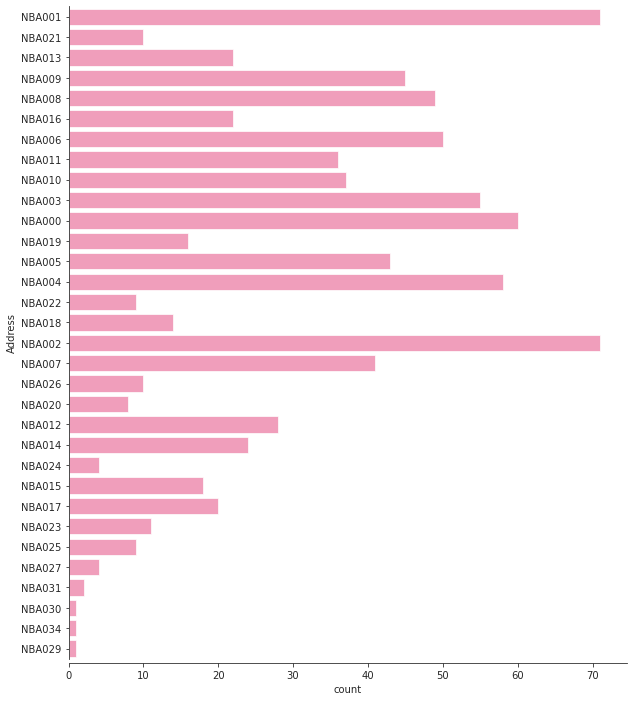

In [6]:
plot_countplot(df, 'Address', figsize=(10, 12), orient='h')

In [7]:
address_dummies = pd.get_dummies(df.Address)
address_dummies.sample(5)

# later, during the modelling stage we'll join this dummies `df` to our main df

,NBA000,NBA001,NBA002,NBA003,NBA004,NBA005,NBA006,NBA007,NBA008,NBA009,...,NBA022,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034
602,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
751,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
594,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(f'{len(df[df.Defaulted.isnull()])} values of Defaulted column are missing')
print(f'Defaulted columns unique values: {df.Defaulted.unique()}')

150 values of Defaulted column are missing
Defaulted columns unique values: [ 0.  1. nan]


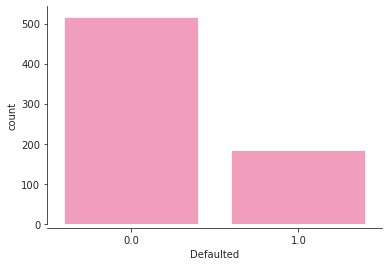

In [9]:
plot_countplot(df, 'Defaulted')
    
    
# giving 0 or 1 randomly for better replacment of missing values
# but as majority of Defaulted values are 0, so keeping the probility
# of value being 0 higher(70%).
# So there is 70% chance of replacement value for missing value being 0
# and 30% chance of it being 1
df.Defaulted = df.Defaulted.apply(
    lambda value: np.random.choice([0, 1], p=[.7, .3])
    if np.isnan(value)
    else value
)

# Here the chances of random choice between 0 and 1 was 70% and 30% respectively
# But that percentage can also be set on the proportion of how Defaulted value is 0
# and 1 out of total numbers of Defaulted (len(df.Defaulted))

`Missing values` problem is sovled

## Exploratory Data Analysis

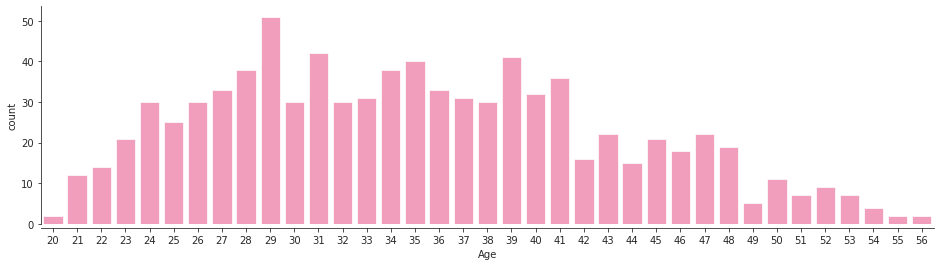

In [10]:
plot_countplot(df, 'Age', figsize=(16, 4))
# The dataset contains mainly age group of 29

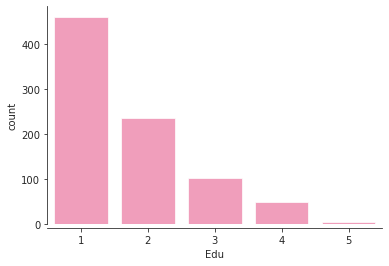

In [11]:
plot_countplot(df, 'Edu')

<AxesSubplot:xlabel='Edu', ylabel='Age'>

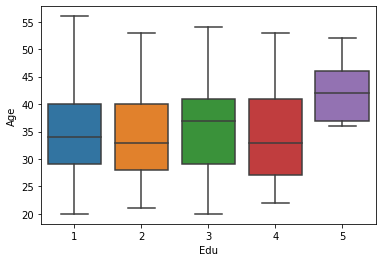

In [12]:
# Relation between Age & Edu
sns.boxplot(x='Edu', y='Age', data=df)

# 5th Edu is done people of higher Age
# Also 1st Edu is done covers the entire scale of Age 

In [13]:
def pearson(data1, data2):
    pearson_corr = pearsonr(data1, data2)[0]
    print(f"Pearson corr: {round(pearson_corr, 2)}")

In [14]:
def plot_corr(df, figsize=(12, 6), annot=False):
    # the `corr` method uses pearson correaltion
    corr = df.corr()
    
    _, ax = plt.subplots(1, 1, figsize=figsize)
    g = sns.heatmap(corr, ax=ax, annot=annot, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

    for _ax in g.get_xticklabels():
        _ax.set_rotation(15)

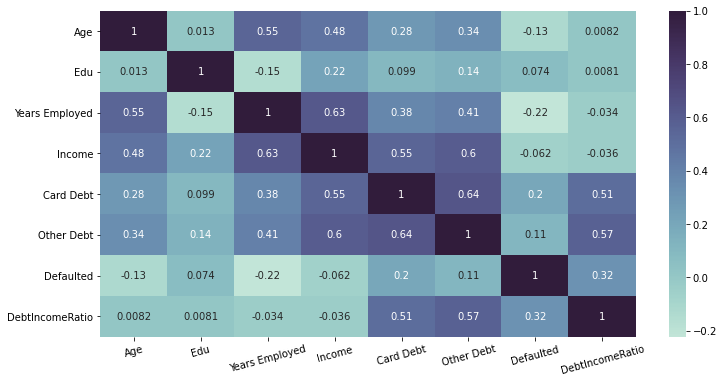

In [15]:
plot_corr(df, annot=True)

> Though the plot might show that there is strong relation between `Age` & `Years Employeed` but that is just because Years Employeed data is very much spreaded. Their `pearson` correlation is 0.55 indicating they have moderate corr
>
> `Age` and `Income` have moderate correlation
>
> `Edu` is have a very low correlation with other columns in the dataset.
>
> `Years Employed` has a moderate correlation between `Age`, `Income` & `Other Debt`
>
> `Other Debt` & `Card Debt` also have moderate correlation with `Income` & `DebtIncomeRation` (as the name suggest that its Debt and Income's ration. Also `Other Debt` & `Card Debt` have a moderate correlation with themselves
> 
> `Defauled` has low but only worth while correlation with `DebtIncomeRation`|

In [16]:
def plot_address_relation(_with, figsize=(12, 20)):
    _, ax = plt.subplots(figsize=figsize)
    sns.boxplot(x=_with, y='Address', data=df, ax=ax)

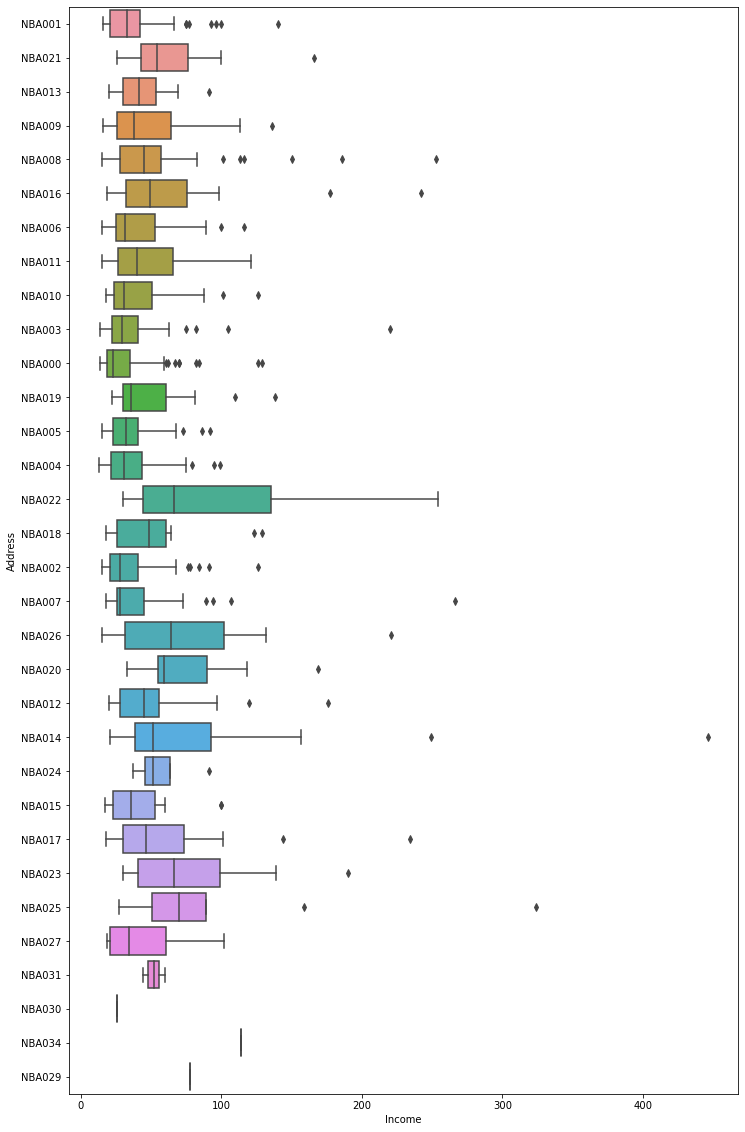

In [17]:
plot_address_relation('Income')
# NBA002 has high Income as compared to others

In [18]:
def plot_debt_effects(plot_func, x):
    _, ax = plt.subplots(1, 3, figsize=(16, 4))

    plot_func(x=x, y='DebtIncomeRatio', data=df, ax=ax[0])
    plot_func(x=x, y='Card Debt', data=df, ax=ax[1])
    plot_func(x=x, y='Other Debt', data=df, ax=ax[2])

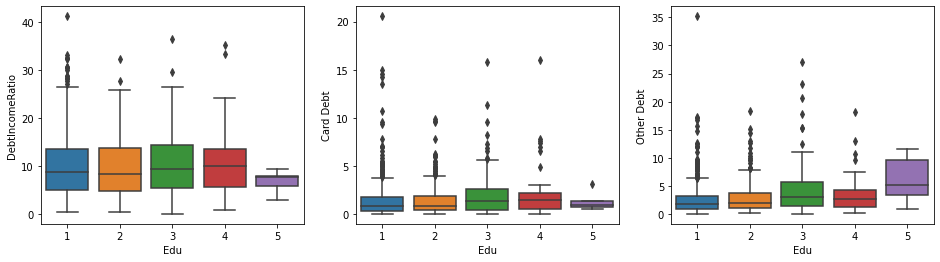

In [19]:
# Effects of Edu on Debt's

plot_debt_effects(sns.boxplot, 'Edu')
    
# People with Edu as 5 have lower DebthIncome Ratio
# The Card Debt is also lower for people with Edu of 5
# But Other Debt is higher for people with Edu of 5

# People with Edu of 3 has relatively high Card Debt, Other Debt & DebtIncomeRation

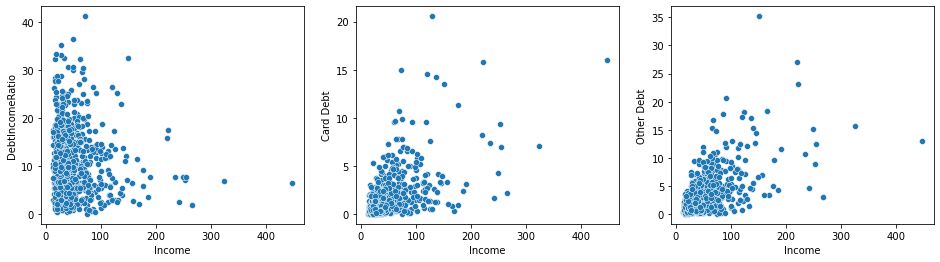

In [20]:
# Effects of Income on Debt's

plot_debt_effects(sns.scatterplot, 'Income')

# People with Edu as 5 have lower DebthIncome Ratio
# The Card Debt is also lower for people with Edu of 5
# But Other Debt is higher for people with Edu of 5

# People with Edu of 3 has relatively high Card Debt, Other Debt & DebtIncomeRation

Since the above boxplots & scatteplots shows that there are some outliers

In [21]:
# Removing outliers using IQR method
def rm_outliers_in_col_using_iqr(df, col):
    # col here is df.column_name (or df[column_name])

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    outliers_row_idx = col.loc[
        (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))
    ].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows', inplace=True)
    return (outliers_row_idx, df)


# Removing outliers using the Zscore method
def rm_outliers_in_col_using_zscore(df, col, column_name):
    # col here is df.column_name (or df[column_name])
    
    zscores_df = pd.DataFrame({
        f'{column_name}': col.to_numpy()
    }, df.index.tolist())
    
    zscores_df['zscores'] = zscores_df.apply(lambda x: zscore(x))
    outliers_row_idx = zscores_df[np.abs(zscores_df.zscores) > 3].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows', inplace=True)
    return (outliers_row_idx, df)


# Remove outliers of a column using iqr & zscore methods
def remove_outliers_of_a_column(df, column_name):
    rm_idxs = []
    for _ in range(10):
        outliers_row_idx, _ = rm_outliers_in_col_using_iqr(df, df[column_name])
        rm_idxs.extend(outliers_row_idx)
        
        outliers_row_idx, _ = rm_outliers_in_col_using_zscore(df, df[column_name], column_name)
        rm_idxs.extend(outliers_row_idx)
    return rm_idxs, df

In [22]:
RM_OUTLIERS_IDXS = []

rm_outliers_idxs_1, _ = remove_outliers_of_a_column(df, 'Other Debt')
rm_outliers_idxs_2, _ = remove_outliers_of_a_column(df, 'Card Debt')
rm_outliers_idxs_3, _ = remove_outliers_of_a_column(df, 'Income')

RM_OUTLIERS_IDXS.extend(rm_outliers_idxs_1)
RM_OUTLIERS_IDXS.extend(rm_outliers_idxs_2)
RM_OUTLIERS_IDXS.extend(rm_outliers_idxs_3)

print(f'Dataset size: {len(df)}')

Dataset size: 605


Again plotting to have better understanding

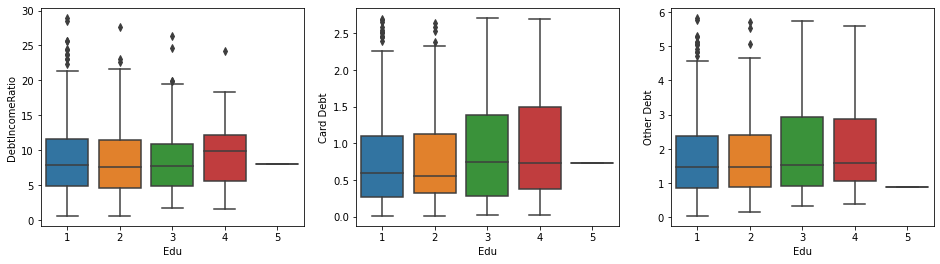

In [23]:
plot_debt_effects(sns.boxplot, 'Edu')

In [24]:
print(f'Remaining 5th level Edu: {len(df[df.Edu == 5])}')

# After removing the outliers majory of 5th level Edu is remove 
# as they were outliers

Remaining 5th level Edu: 1


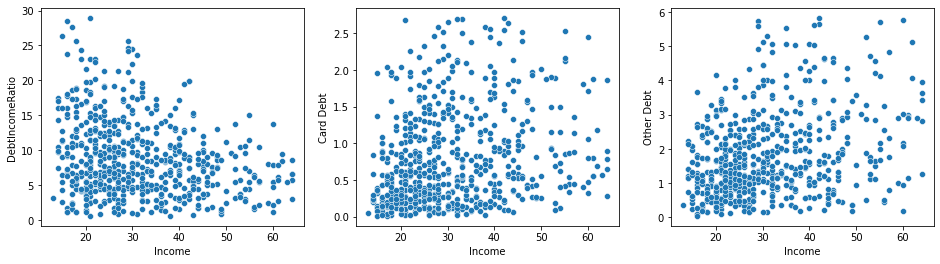

In [25]:
plot_debt_effects(sns.scatterplot, 'Income')

In [26]:
print(pearson(df.Income, df.DebtIncomeRatio))
# Income and DebtIncomeRation has a low negative corr

print(pearson(df.Income, df['Card Debt']))
print(pearson(df.Income, df['Other Debt']))
# While Card & Other Debts have a low positive corr

# This has to do with position of Debt & Income in DebtIncomeRatio

Pearson corr: -0.23
None
Pearson corr: 0.22
None
Pearson corr: 0.33
None


Also after removing outliers let's see the effects on `Address` column

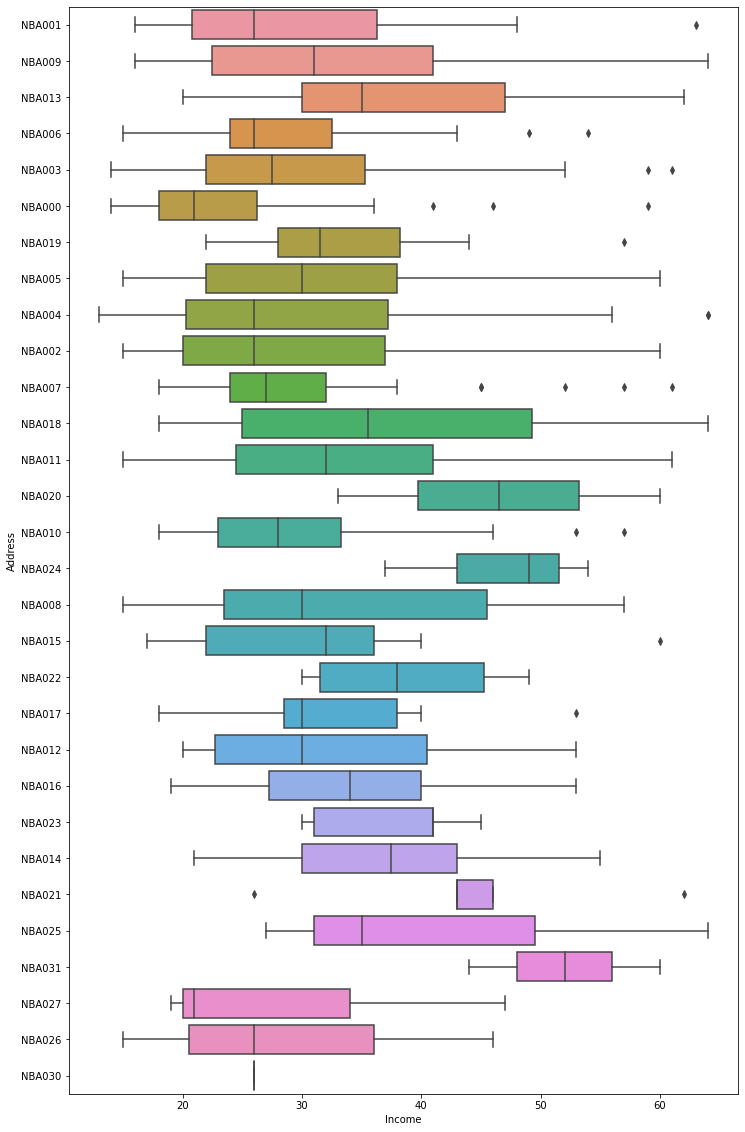

In [27]:
plot_address_relation('Income')

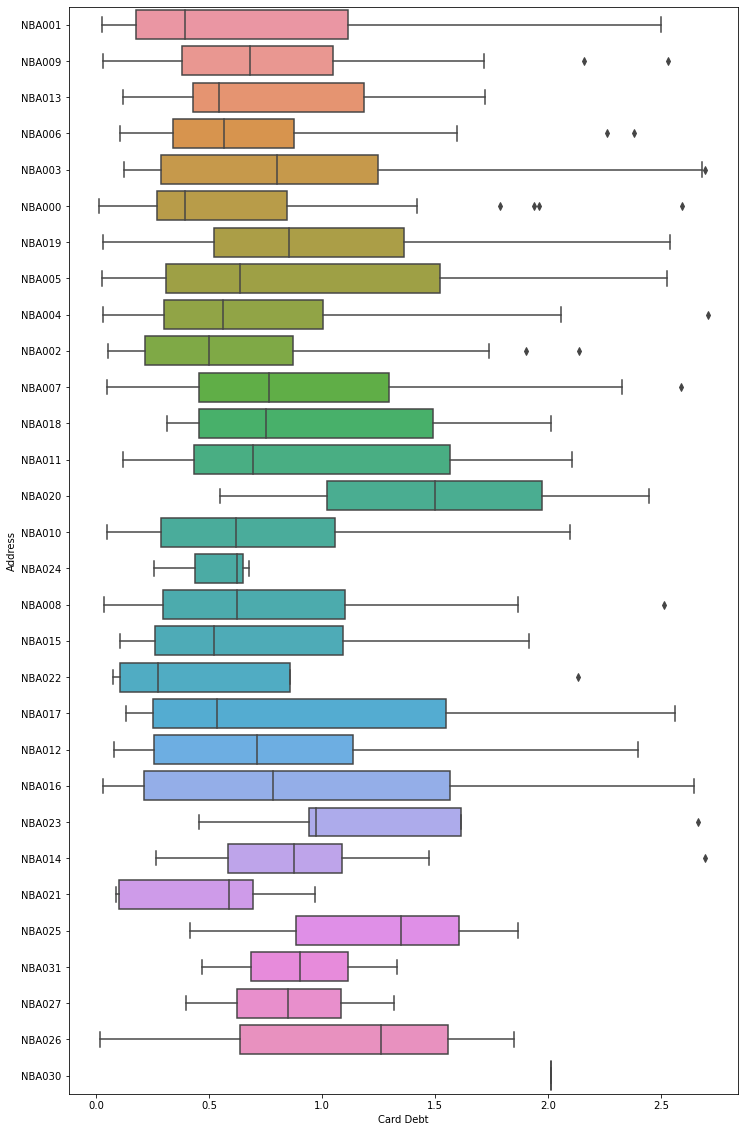

In [28]:
# Address relation with Card Debt
plot_address_relation('Card Debt')

# Here address NBA020's people on average has more Other Card than others

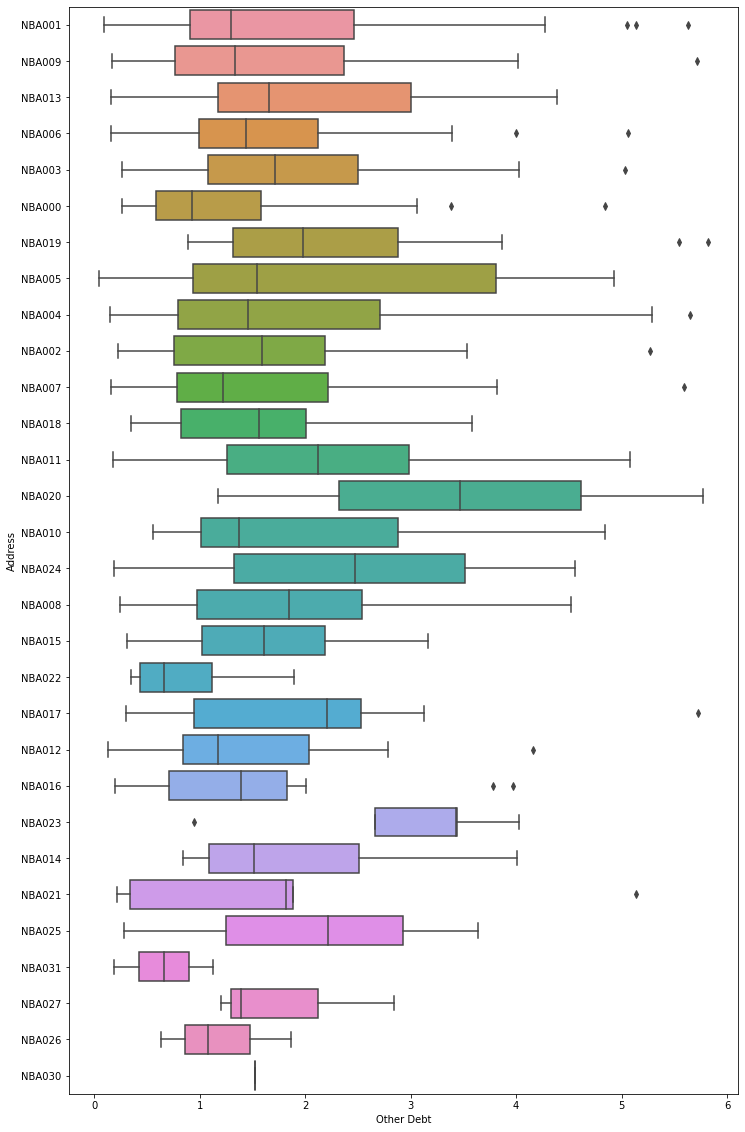

In [29]:
# Address relation with Other Debt
plot_address_relation('Other Debt')

# Here address NBA020's people on average has more Other Debt than others

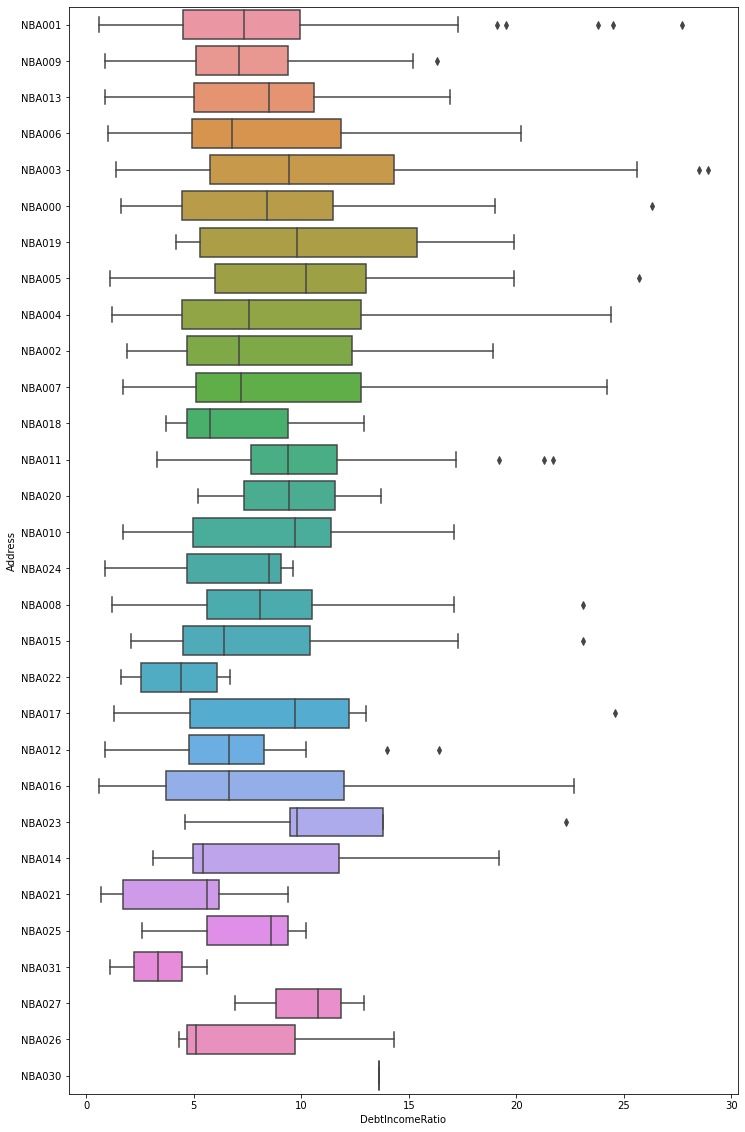

In [30]:
# Address relation with DebtIncomeRatio
plot_address_relation('DebtIncomeRatio')

# Here address NBA019's people on average has more DebtIncomeRatio than others
# while NBA031 has the lowest average DebtIncomeRatio

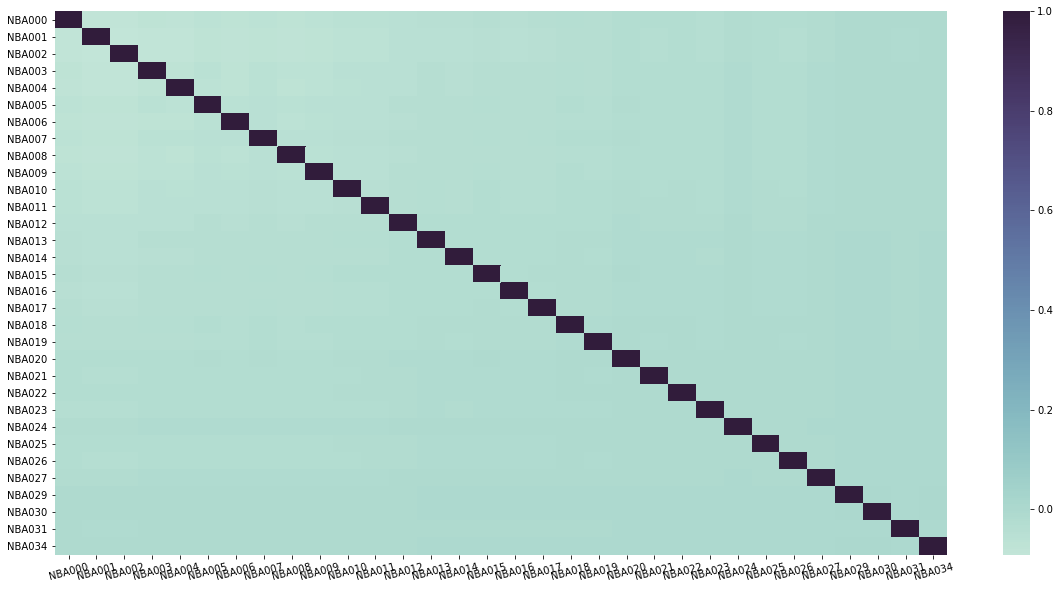

In [31]:
plot_corr(address_dummies, figsize=(20, 10))

The address dummies don't have any `multicollinearity issue`

In [32]:
# Replacing the Address column with its dummies (one-hot-encoded matrix)

# Removing Address column
drop_column(df, 'Address')

# Removing the rows which were oultiers (removed from df)
address_dummies.drop(RM_OUTLIERS_IDXS, axis='rows', inplace=True)

# Concating df & address_dummies
df = pd.concat([df, address_dummies], axis='columns')
df.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,NBA000,NBA001,...,NBA022,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034
172,31,3,9,28,0.122,0.606,0.0,2.6,0,0,...,0,0,0,0,0,0,0,0,0,0
537,35,1,7,29,0.264,1.157,0.0,4.9,0,0,...,0,0,0,0,0,0,0,0,0,0
265,55,1,3,40,0.563,2.637,1.0,8.0,0,0,...,0,0,0,0,0,0,0,0,0,0
766,38,2,7,64,0.651,1.269,0.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,22,2,0,35,0.781,2.369,1.0,9.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
for column in df.columns:
    if len(df[df.Age.isnull()]) > 0:
        print(f'WARNING: Missing values are detected in {column}')

## Modelling

In [34]:
# Scaling the input data
x = df.values
x = StandardScaler().fit_transform(x)
len(x)

605

In [35]:
def km_param_selection(x):
    n_clusters = [i for i in range(1, 10)]
    init = ['k-means++', 'random']
    algorithm = ['auto', 'full', 'elkan']

    param_grid = {
        'n_clusters': n_clusters,
        'init': init,
        'algorithm': algorithm
    }

    grid_search = GridSearchCV(KMeans(), param_grid)
    grid_search.fit(x)
    best_score = grid_search.best_score_
    best_parameters = grid_search.best_estimator_.get_params()
    return (best_score, best_parameters)


best_score ,best_params = km_param_selection(x)
print(best_score)
print(best_params)

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:828: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  "cluster. Using 'full' instead.", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:828: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  "cluster. Using 'full' instead.", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:828: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  "cluster. Using 'full' instead.", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:828: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  "cluster. Using 'full' instead.", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:828: RuntimeWarning: algorithm='elkan' doesn't make se

-3742.8699309338795
{'algorithm': 'elkan', 'copy_x': True, 'init': 'random', 'max_iter': 300, 'n_clusters': 9, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [36]:
# Fitting the model
model = KMeans(
    algorithm=best_params['algorithm'], 
    copy_x=best_params['copy_x'],
    init=best_params['init'], 
    max_iter=best_params['max_iter'],
    n_clusters=best_params['n_clusters'],
    precompute_distances=best_params['precompute_distances'],
    tol=best_params['tol'],
    n_jobs=best_params['n_jobs']
)

model.fit(x)

KMeans(algorithm='elkan', init='random', n_clusters=9)

In [37]:
labels = model.labels_
print(labels)

[8 7 2 7 5 3 0 2 0 2 5 2 2 7 5 3 6 0 2 7 8 7 6 3 3 7 0 0 4 3 3 6 3 5 4 0 6
 5 2 7 2 5 5 3 2 0 6 3 2 4 8 7 7 3 8 5 3 5 8 5 3 0 1 4 5 0 3 2 3 3 2 5 3 2
 3 4 3 2 2 3 2 5 5 3 5 2 4 2 5 5 8 2 2 2 7 0 2 0 3 2 5 8 5 2 3 3 3 5 8 5 0
 7 0 5 7 5 2 3 3 5 2 2 3 3 3 0 6 2 2 8 2 2 8 7 7 3 0 7 5 5 5 2 5 2 3 5 2 3
 8 3 7 2 5 2 5 5 3 8 7 3 5 2 2 2 3 4 2 3 5 8 5 5 2 0 5 0 2 3 4 5 3 4 5 5 7
 7 2 3 0 5 3 2 0 4 3 0 7 2 8 2 0 5 8 7 3 2 3 2 4 0 5 5 2 5 2 2 3 5 2 5 2 8
 8 5 3 6 2 3 3 2 2 4 0 3 7 2 3 2 2 2 5 8 3 6 5 2 6 7 2 2 8 4 3 3 7 5 0 2 6
 3 3 5 3 2 3 8 5 3 5 2 3 7 2 2 5 6 7 5 8 3 5 6 3 7 2 3 2 2 8 7 3 2 2 8 2 2
 3 3 2 6 0 4 8 2 6 8 7 2 1 7 2 5 5 2 7 2 5 8 8 2 8 3 7 2 8 7 8 2 2 3 6 5 7
 0 1 6 6 3 3 2 3 2 2 3 8 5 2 3 6 3 4 0 3 6 8 7 2 6 5 2 2 2 2 3 6 2 5 2 0 4
 5 5 8 3 2 0 5 2 8 3 2 2 2 8 2 6 5 0 3 5 8 2 2 2 0 2 3 5 2 7 0 3 3 7 0 5 6
 6 5 3 7 5 5 2 2 5 5 7 2 2 5 5 2 2 4 0 5 5 3 5 5 2 5 3 2 2 5 8 5 8 2 2 7 3
 5 2 2 0 2 0 3 8 5 0 3 5 2 5 2 6 3 5 5 8 5 6 2 3 7 5 8 4 2 5 6 5 5 5 2 8 3
 3 3 2 2 8 7 3 2 5 7 0 5 

In [38]:
# We assign the labels to each row in dataframe
df['Clus_km'] = labels
df.head(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,NBA000,NBA001,...,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034,Clus_km
0,41,2,6,19,0.124,1.073,0.0,6.3,0,1,...,0,0,0,0,0,0,0,0,0,8
3,29,2,4,19,0.681,0.516,0.0,6.3,0,0,...,0,0,0,0,0,0,0,0,0,7
6,38,2,4,56,0.442,0.454,0.0,1.6,0,0,...,0,0,0,0,0,0,0,0,0,2
7,42,3,0,64,0.279,3.945,0.0,6.6,0,0,...,0,0,0,0,0,0,0,0,0,7
8,26,1,5,18,0.575,2.215,0.0,15.5,0,0,...,0,0,0,0,0,0,0,0,0,5


In [39]:
# Checking the centroid values by averaging the features in each cluster
df.groupby('Clus_km').mean()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,NBA000,NBA001,...,NBA022,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034
Clus_km,,,,,,,,,,,,,,,,,,,,,
0,28.000000,1.520833,3.979167,23.395833,0.639375,1.249104,0.458333,8.700000,1.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,44.333333,2.000000,7.666667,46.666667,0.517333,2.406000,0.000000,6.333333,0.0,0.0,...,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,36.779070,1.622093,7.313953,32.953488,0.893186,1.933436,0.191860,8.961047,0.0,0.0,...,0.023256,0.02907,0.0,0.000000,0.017442,0.017442,0.0,0.005814,0.000000,0.0
3,29.528302,1.566038,5.518868,29.358491,0.752755,1.750991,0.358491,9.563208,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,38.869565,1.347826,6.608696,33.173913,0.940913,2.290087,0.347826,10.247826,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
5,30.783784,1.639640,6.153153,30.369369,0.738099,1.806703,0.270270,8.749550,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
6,30.969697,1.757576,5.878788,30.181818,0.948970,1.641818,0.212121,8.875758,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7,38.301887,1.603774,8.547170,36.943396,0.853585,1.771774,0.113208,7.184906,0.0,0.0,...,0.000000,0.00000,0.0,0.056604,0.000000,0.000000,0.0,0.000000,0.037736,0.0
8,28.571429,1.660714,4.517857,29.053571,0.714964,1.707179,0.196429,8.460714,0.0,1.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


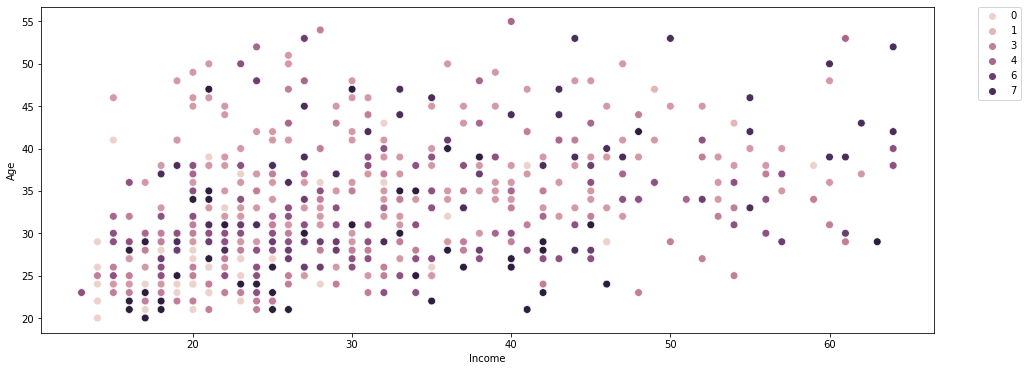

In [40]:
_, ax = plt.subplots(figsize=(16, 6))
sns.scatterplot(x='Income', y='Age', hue='Clus_km', data=df, s=60, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

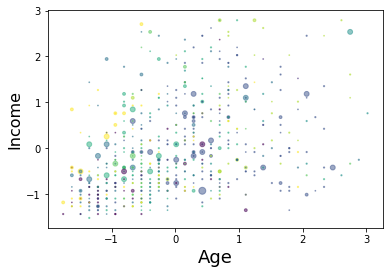

In [41]:
area = np.pi * ( x[:, 1])**2  
plt.scatter(x[:, 0], x[:, 3], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)

plt.show()

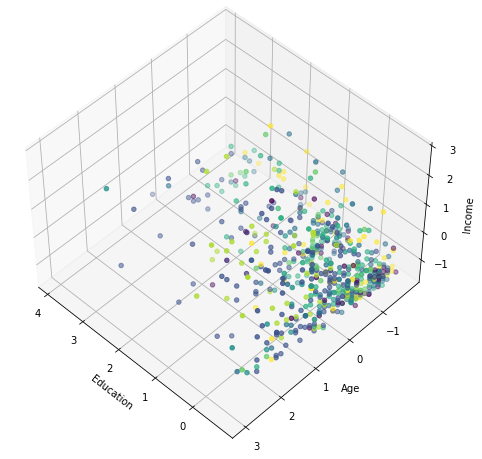

In [42]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')

ax.scatter(x[:, 1], x[:, 0], x[:, 3], c= labels.astype(np.float))

#### But since we want to do segment custormers into 3 groups therefore n_custers=3

In [43]:
df.drop(['Clus_km'], axis='columns', inplace=True)
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,NBA000,NBA001,...,NBA022,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034
0,41,2,6,19,0.124,1.073,0.0,6.3,0,1,...,0,0,0,0,0,0,0,0,0,0
3,29,2,4,19,0.681,0.516,0.0,6.3,0,0,...,0,0,0,0,0,0,0,0,0,0
6,38,2,4,56,0.442,0.454,0.0,1.6,0,0,...,0,0,0,0,0,0,0,0,0,0
7,42,3,0,64,0.279,3.945,0.0,6.6,0,0,...,0,0,0,0,0,0,0,0,0,0
8,26,1,5,18,0.575,2.215,0.0,15.5,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
def km_param_selection_v2(x):
    init = ['k-means++', 'random']
    algorithm = ['auto', 'full', 'elkan']

    param_grid = {
        'init': init,
        'algorithm': algorithm
    }

    grid_search = GridSearchCV(KMeans(n_clusters=3), param_grid)
    grid_search.fit(x)
    best_score = grid_search.best_score_
    best_parameters = grid_search.best_estimator_.get_params()
    return (best_score, best_parameters)


best_score ,best_params = km_param_selection_v2(x)
print(best_score)
print(best_params)

-4333.271152820846
{'algorithm': 'auto', 'copy_x': True, 'init': 'random', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [45]:
# Fitting the model
model = KMeans(
    algorithm=best_params['algorithm'], 
    copy_x=best_params['copy_x'],
    init=best_params['init'], 
    max_iter=best_params['max_iter'],
    n_clusters=best_params['n_clusters'],
    precompute_distances=best_params['precompute_distances'],
    tol=best_params['tol'],
    n_jobs=best_params['n_jobs']
)

model.fit(x)

KMeans(init='random', n_clusters=3)

In [46]:
labels = model.labels_
print(labels)

[2 2 1 1 2 1 2 0 2 2 2 0 1 1 0 2 0 1 1 0 2 1 1 2 2 2 2 2 0 2 2 2 1 0 2 2 2
 1 1 0 0 2 1 2 0 2 1 2 2 1 2 1 1 2 2 2 2 0 2 2 2 2 1 1 1 0 2 1 0 2 1 0 1 1
 0 1 2 2 1 2 1 2 2 2 1 1 1 1 2 0 2 1 1 0 1 2 0 2 1 0 2 0 2 0 2 2 1 2 0 0 2
 2 2 1 1 2 0 2 2 0 1 1 2 1 2 0 1 1 1 0 2 1 2 1 1 0 2 1 2 2 1 1 1 1 2 1 1 2
 2 2 1 2 2 0 1 0 2 2 1 2 2 2 1 2 2 1 1 2 2 0 1 0 1 2 2 2 1 2 1 2 2 1 2 2 1
 1 0 2 0 2 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 0 1 0 1 1 2 1 2 1 2 2 0 1 2 1 2
 2 1 2 2 0 1 2 0 1 0 2 0 1 0 1 1 0 1 2 2 2 2 1 1 1 1 0 1 2 0 2 2 2 1 2 0 1
 0 1 2 2 1 2 2 1 1 0 1 2 1 1 2 1 2 1 2 0 2 2 2 0 1 1 1 1 0 2 1 0 2 1 2 1 0
 2 0 0 2 0 2 2 2 1 2 1 1 1 1 0 0 1 0 1 1 0 2 2 0 0 2 1 1 0 0 2 1 2 1 0 1 1
 2 1 1 1 0 0 0 2 1 1 2 2 0 1 1 2 2 1 2 2 0 2 1 1 0 2 0 0 1 0 2 1 2 0 1 2 1
 2 2 0 0 0 2 0 2 2 2 1 1 1 2 0 1 0 2 2 2 2 1 1 0 2 1 1 0 2 1 2 2 0 1 2 1 0
 0 2 2 0 2 1 1 1 2 2 2 1 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 0 0 2 0
 2 2 0 2 1 2 0 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 1 1 1 2 0 1 1 2 2 2 1 0 1 2 2
 1 0 1 1 2 1 2 2 1 1 2 2 

In [47]:
# We assign the labels to each row in dataframe
df['Clus_km'] = labels
df.head(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,NBA000,NBA001,...,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034,Clus_km
0,41,2,6,19,0.124,1.073,0.0,6.3,0,1,...,0,0,0,0,0,0,0,0,0,2
3,29,2,4,19,0.681,0.516,0.0,6.3,0,0,...,0,0,0,0,0,0,0,0,0,2
6,38,2,4,56,0.442,0.454,0.0,1.6,0,0,...,0,0,0,0,0,0,0,0,0,1
7,42,3,0,64,0.279,3.945,0.0,6.6,0,0,...,0,0,0,0,0,0,0,0,0,1
8,26,1,5,18,0.575,2.215,0.0,15.5,0,0,...,0,0,0,0,0,0,0,0,0,2


In [48]:
# Checking the centroid values by averaging the features in each cluster
df.groupby('Clus_km').mean()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,NBA000,NBA001,...,NBA022,NBA023,NBA024,NBA025,NBA026,NBA027,NBA029,NBA030,NBA031,NBA034
Clus_km,,,,,,,,,,,,,,,,,,,,,
0,34.644628,1.785124,5.545455,31.057851,1.525537,3.292380,0.404959,16.292562,0.033058,0.099174,...,0.000000,0.024793,0.000000,0.000000,0.000000,0.000000,0.0,0.008264,0.000000,0.0
1,37.949541,1.541284,9.793578,39.220183,0.733711,1.646812,0.064220,6.242202,0.013761,0.009174,...,0.018349,0.009174,0.013761,0.013761,0.013761,0.013761,0.0,0.000000,0.009174,0.0
2,27.936090,1.582707,3.706767,24.248120,0.531154,1.221241,0.345865,7.570677,0.154135,0.157895,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


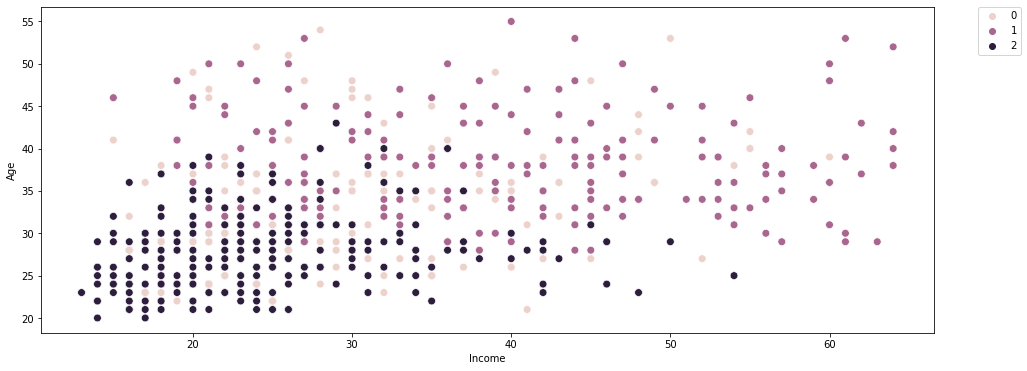

In [49]:
_, ax = plt.subplots(figsize=(16, 6))
sns.scatterplot(x='Income', y='Age', hue='Clus_km', data=df, s=60, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

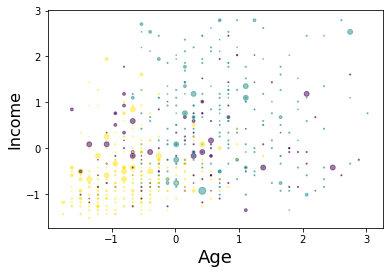

In [50]:
area = np.pi * ( x[:, 1])**2  
plt.scatter(x[:, 0], x[:, 3], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=16)

plt.show()

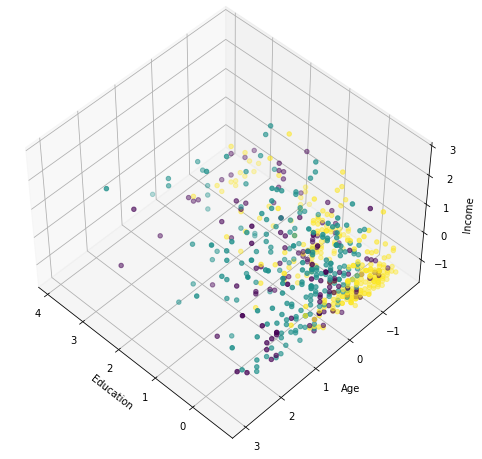

In [51]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')

ax.scatter(x[:, 1], x[:, 0], x[:, 3], c= labels.astype(np.float))

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/fzZzoftMBR8is/giphy.gif)

---